In [45]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product

In [47]:
cow_df = pd.read_csv("한우 등급별 월별도매가격 - 복사본.csv")

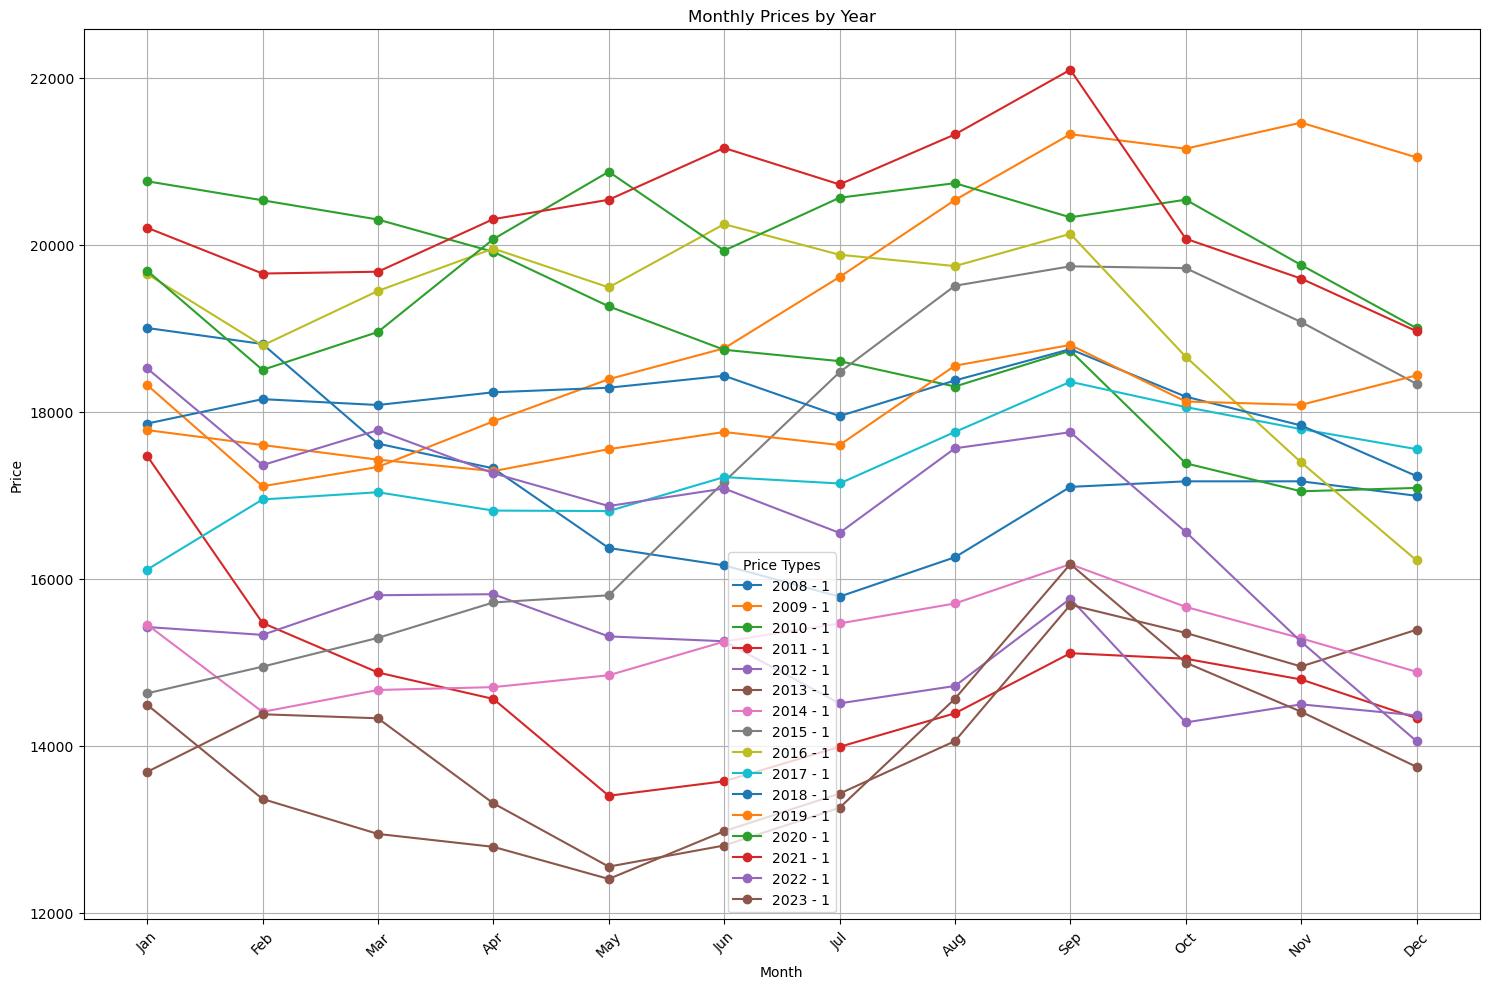

In [49]:
# 'Month-Year' 열을 datetime으로 변환
cow_df['Date'] = pd.to_datetime(cow_df['년-월'] , format='%y-%b')

# X축을 월로 설정하기 위해 월 숫자 추출
cow_df['Month'] = cow_df['Date'].dt.month
cow_df['Month_Name'] = cow_df['Date'].dt.strftime('%b')
cow_df['year'] = cow_df['Date'].dt.year

# 연도별 데이터 나누기
years = cow_df['Date'].dt.year.unique()

# 월 이름 리스트
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 연도별 그래프 그리기
plt.figure(figsize=(15, 10))
# 색상 목록
colors = plt.get_cmap('tab10').colors  # 탭10 색상 팔레트

for year in years:
    yearly_data = cow_df[cow_df['Date'].dt.year == year]
    plt.plot(yearly_data['Month_Name'], yearly_data['1'], label=f'{year} - 1', marker='o')


plt.title('Monthly Prices by Year')
plt.xlabel('Month')
plt.ylabel('Price')
plt.xticks(ticks=months, labels=months, rotation=45)
plt.legend(title='Price Types')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
cow_df

,년-월,1++,1+,1,2,Date,Month,Month_Name,year
0,08-Jan,22901.14757,20577.05859,19004.17757,17435.07147,2008-01-01,1,Jan,2008
1,08-Feb,23208.93558,20908.60087,18812.60107,16692.78309,2008-02-01,2,Feb,2008
2,08-Mar,22159.84599,19619.94659,17619.07719,15669.12998,2008-03-01,3,Mar,2008
3,08-Apr,22091.84556,19619.08056,17322.94163,14571.03332,2008-04-01,4,Apr,2008
4,08-May,21445.54698,18658.58140,16368.98199,13765.77239,2008-05-01,5,May,2008
...,...,...,...,...,...,...,...,...,...
187,23-Aug,19293.72996,16293.19558,14563.59102,11066.08479,2023-08-01,8,Aug,2023
188,23-Sep,20191.40452,17733.27426,16176.34027,12554.71865,2023-09-01,9,Sep,2023
189,23-Oct,18873.48813,16240.84047,14996.02719,11778.05244,2023-10-01,10,Oct,2023
190,23-Nov,18333.33333,15741.92403,14408.05822,12230.20944,2023-11-01,11,Nov,2023


C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


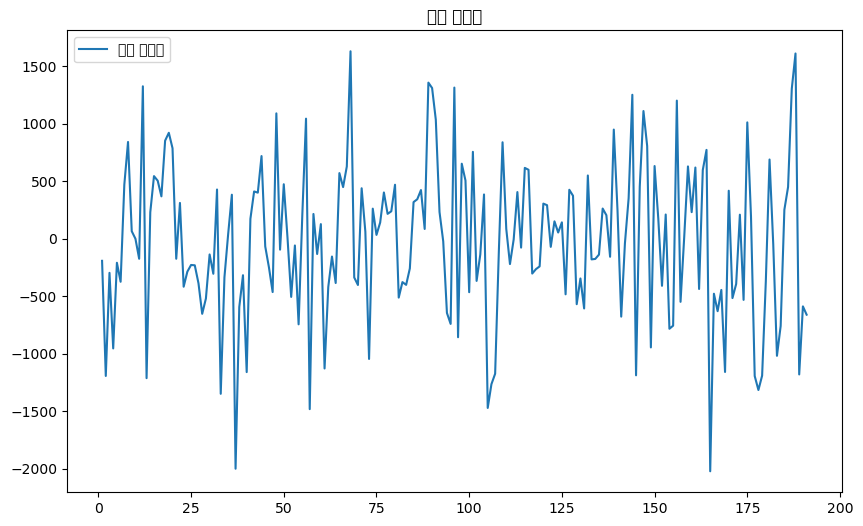

ADF Statistic: -3.971630933456861
ADF p-value: 0.0015665662585834966
KPSS Statistic: 0.08212280739176253
KPSS p-value: 0.1


C:\Users\임재성\AppData\Local\Temp\ipykernel_1316\1495876674.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(differenced, regression='c')


In [9]:
# 1차 차분
differenced = cow_df['1'].diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(differenced, label='차분 데이터')
plt.title('차분 데이터')
plt.legend()
plt.show()

# 정상성 검정
result_adf = adfuller(differenced)
result_kpss = kpss(differenced, regression='c')

print("ADF Statistic:", result_adf[0])
print("ADF p-value:", result_adf[1])
print("KPSS Statistic:", result_kpss[0])
print("KPSS p-value:", result_kpss[1])

In [11]:
# 계절 차분 (예: 계절성 주기가 12일 경우)
seasonal_period = 12
seasonal_differenced = differenced - differenced.shift(seasonal_period)
seasonal_differenced = seasonal_differenced.dropna()

In [13]:
seasonal_differenced

13    -1021.03397
14     1424.51701
15      841.68142
16     1459.55216
17      578.01210
          ...    
187     293.21712
188    1420.11026
189      13.68669
190     727.78630
191     530.54313
Name: 1, Length: 179, dtype: float64

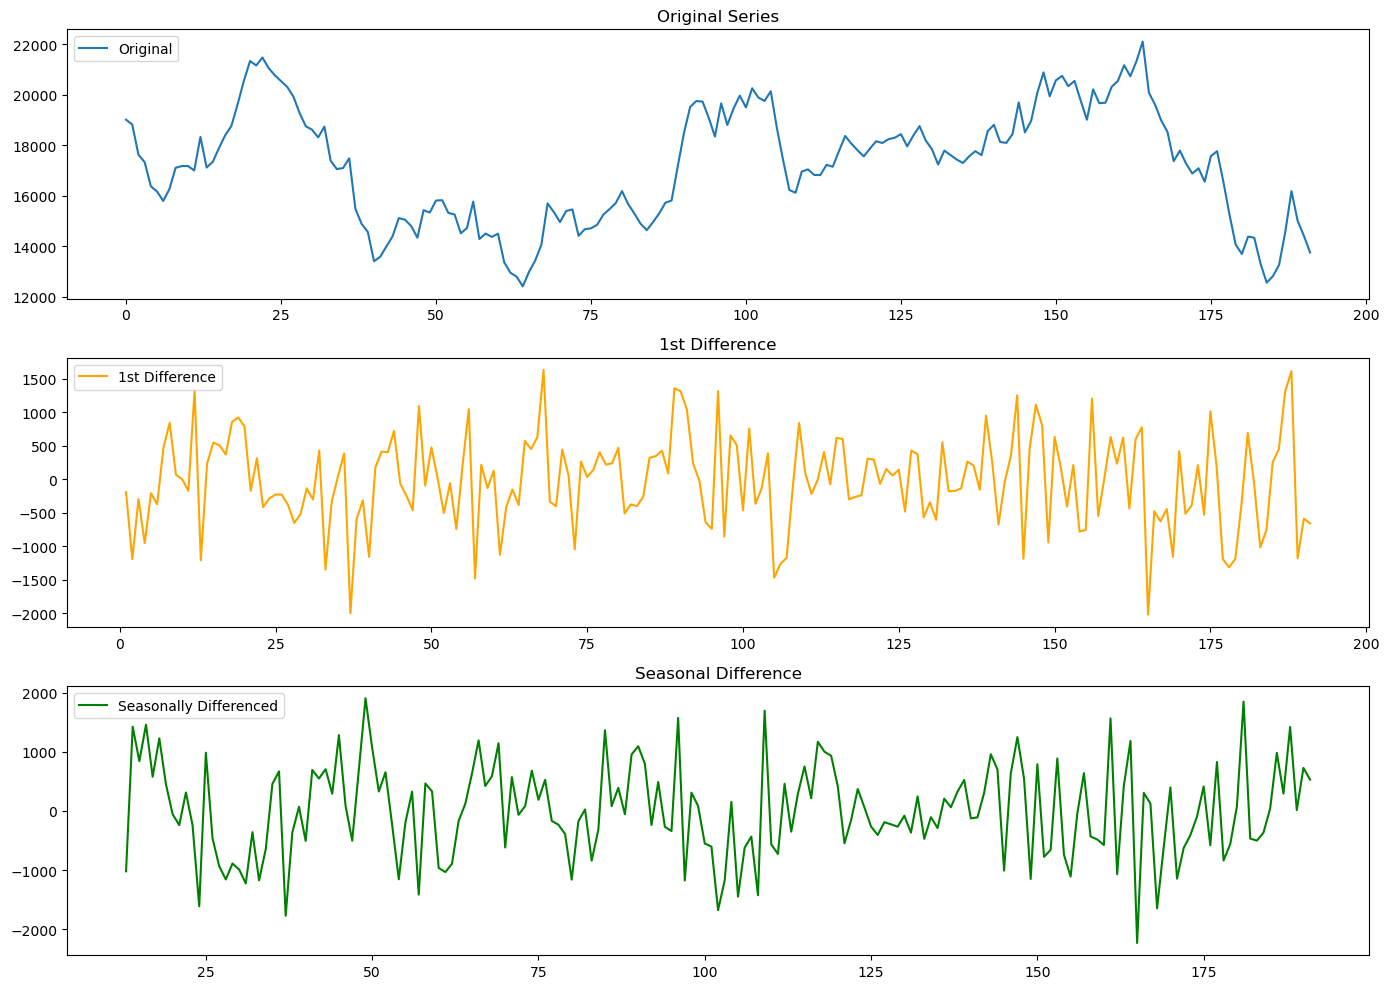

In [15]:

# 결과 시각화
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(cow_df['1'], label='Original')
plt.title('Original Series')
plt.legend(loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(differenced, label='1st Difference', color='orange')
plt.title('1st Difference')
plt.legend(loc='upper left')

plt.subplot(3, 1, 3)
plt.plot(seasonal_differenced, label='Seasonally Differenced', color='green')
plt.title('Seasonal Difference')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
# 정상성 검정
result_adf = adfuller(seasonal_differenced)
result_kpss = kpss(seasonal_differenced, regression='c')

print("ADF Statistic:", result_adf[0])
print("ADF p-value:", result_adf[1])
print("KPSS Statistic:", result_kpss[0])
print("KPSS p-value:", result_kpss[1])

ADF Statistic: -7.18630580913722
ADF p-value: 2.5714952582668135e-10
KPSS Statistic: 0.031140679834575236
KPSS p-value: 0.1


C:\Users\임재성\AppData\Local\Temp\ipykernel_1316\3073517010.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(seasonal_differenced, regression='c')


<Figure size 1200x600 with 0 Axes>

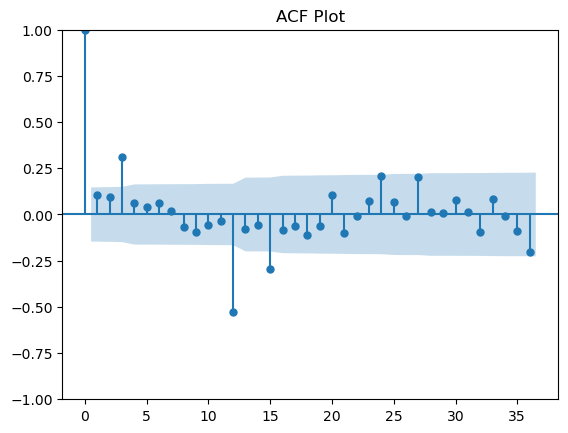

In [23]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(seasonal_differenced, lags=36)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

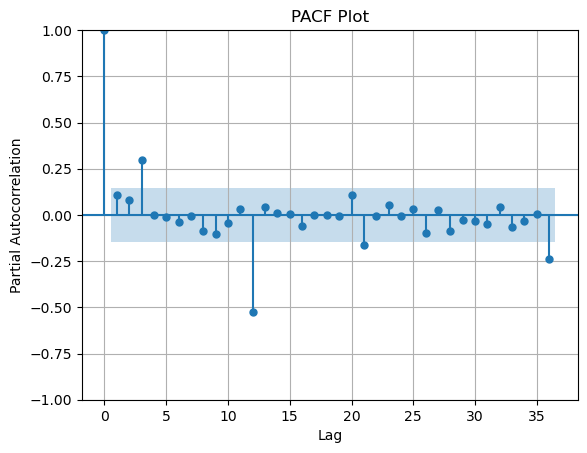

In [21]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(seasonal_differenced, lags=36)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [29]:
seasonal_differenced

13    -1021.03397
14     1424.51701
15      841.68142
16     1459.55216
17      578.01210
          ...    
187     293.21712
188    1420.11026
189      13.68669
190     727.78630
191     530.54313
Name: 1, Length: 179, dtype: float64

In [43]:
acf_values = acf(seasonal_differenced, nlags=40)
lags = np.arange(len(acf_values))

# 급격한 변화 시점 출력
for i in range(1, len(acf_values)):
    if abs(acf_values[i]) > 0.5:  # 예를 들어, 자기 상관 값이 0.5를 초과하는 경우
        print(f"Lag {i}: ACF = {acf_values[i]}")

Lag 12: ACF = -0.529637475775377
